# Задача:
#### Необходимо уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель для предсказания температуры стали. 

# Описание этапов обработки:
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных:


Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.
# Цель MAE:
Целевой признак: последняя измеренная температура.

Метрика: MAE

Критерии оценки:

- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp


 # План работы:
 - 1. Загрузка и оценка данных;
 - 2. Переработка данных;
 - 3. Подготовка данных:
     - очистка данных
     - создание и подготовка признаков
 - 4. Обучение моделей LightGBM,LinearRegression,RandomForesst и СatBoost;
 - 5. Сравненние результатов и выбор лучшуей модели;
 - 6. Тестирование модель на тестовой выборке;
 - 7. Отчет. 

# Шаг 1 
### Загрузим данные 

In [1]:
from scipy import stats as st
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_wire = pd.read_csv('data_wire.csv')
df_wire_time = pd.read_csv('data_wire_time.csv')
df_temp = pd.read_csv('data_temp.csv')
df_gas = pd.read_csv('data_gas.csv')
df_bulk = pd.read_csv('data_bulk.csv')
df_bulk_time = pd.read_csv('data_bulk_time.csv')
df_arc =  pd.read_csv('data_arc.csv')

In [3]:
display(df_wire)
display(df_wire_time) 
display(df_temp) 
display(df_gas) 
display(df_bulk) 
display(df_bulk_time) 
display(df_arc) 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [4]:
display(df_wire.info())
display(df_wire_time.info()) 
display(df_temp.info()) 
display(df_gas.info()) 
display(df_bulk.info()) 
display(df_bulk_time.info())
display(df_arc.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

### Вывод :
Имеем 7 датасетов с разным количеством строк и столбцов. На первый взгляд мы имеем достаточно большое количество пропусков нескольких из них и неправильный тип данных. Разберемся с этим подробнее в Шаге 2. : 


#  Шаг 2
### Переработка данных

Рассмотрим датасет с информацией по температуре:

In [5]:
display(df_temp.info())
display(df_temp)
display(df_temp.describe())
display(df_temp.duplicated().sum())
df_temp['Температура'].isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


0

2901

<AxesSubplot:>

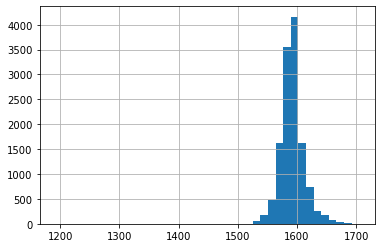

In [6]:
df_temp['Температура'].hist(bins = 40)

Переведем столбец  c датой в правильный формат datetime:

In [7]:
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])

array(['Время замера'], dtype=object)

key - 0%
Время замера - 0%
Температура - 18%


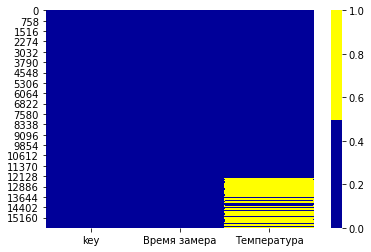

In [8]:
df_non_numeric = df_temp.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
display(non_numeric_cols)
cols = df_temp.columns[:50] 
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df_temp[cols].isnull(), cmap=sns.color_palette(colours))
for col in df_temp.columns:
    pct_missing = np.mean(df_temp[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

In [9]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
#print(df_temp)

In [10]:
df_temp_clean = df_temp.dropna()
df_temp_clean['Время замера'] = pd.to_datetime(df_temp_clean['Время замера'])
display(df_temp_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


None

In [11]:
df_temp_polate = df_temp.interpolate(method ='linear', limit_direction = 'forward', axis = 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   15907 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None

<AxesSubplot:>

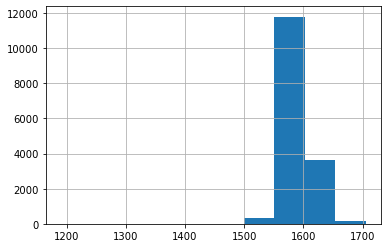

In [12]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
display(df_temp_polate.info())
df_temp_polate['Температура'].hist()

<AxesSubplot:>

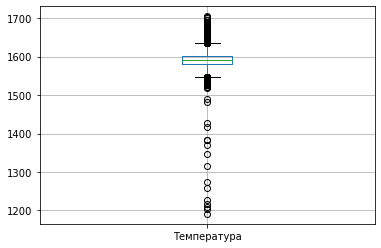

In [13]:
df_temp_polate.boxplot(column = ['Температура'])

<AxesSubplot:>

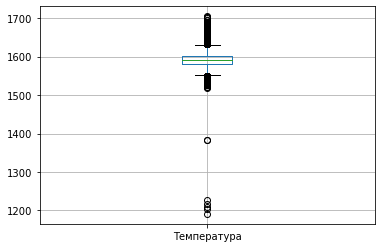

In [14]:
df_temp_clean.boxplot(column = ['Температура'])

### Вывод:  
- изменили тип данных на правильный;
- избавились от пропусков двумя разными способами в дальнейшем решим какой лучше( скорее всего достаточно избавиться от пропусков методом dropna())
- есть возможные вбросы после отметки 1400 включительно

## Разберем датасет с информацией об электродах:

In [15]:
display(df_arc.info())
display(df_arc)
display(df_arc.describe())
display(df_arc.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


0


Данные чистые без пропусков, но видно, что тип данных в столбцах 'Начало нагрева дугой' и 'Конец нагрева дугой'  не соответствует самим данным, также в столбце 'Реактивная мощность' есть значение '-715' предположим, что это ошибка в данных и проверим это на графике, также  изменим  тип данных в двух столбцах с мощностью  на правильный тип datetime.

In [16]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])
df_arc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Построим гистограммы и ящики с усами для столбцов с мощностями: 

<AxesSubplot:>

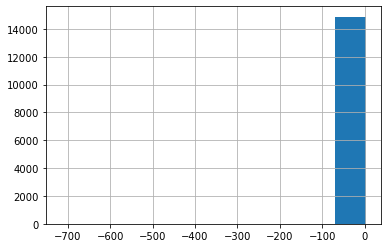

In [17]:
display(df_arc['Реактивная мощность'].hist(bins = 10))

<AxesSubplot:>

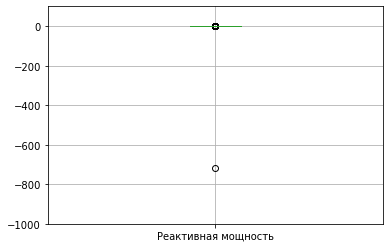

In [18]:
plt.ylim(-1000, 100)
df_arc.boxplot(column = ['Реактивная мощность'])

<AxesSubplot:xlabel='Активная мощность', ylabel='Count'>

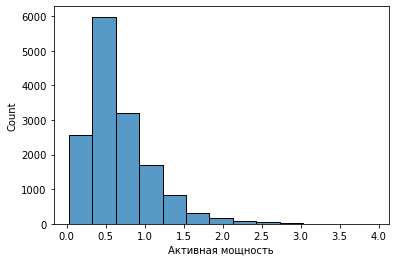

In [19]:
sns.histplot(df_arc["Активная мощность"], binwidth=0.3)

<AxesSubplot:>

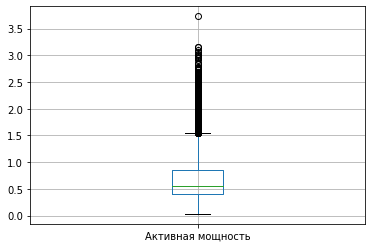

In [20]:
df_arc.boxplot(column = ['Активная мощность'])

В столбце 'Реактивная мощность' потвердилось явное аномальное значение в -715 избавимся от него. 

In [21]:
df_arc = df_arc[df_arc['Реактивная мощность'] > 0]


In [22]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


#### Вывод:
 - изменили тип данных
 - разобрались с выбросами

Рассмотрим датасет с данными по газу:

In [23]:
display(df_gas)
display(df_gas.describe())
display(df_gas.duplicated().sum())
display(df_gas.info())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

<AxesSubplot:>

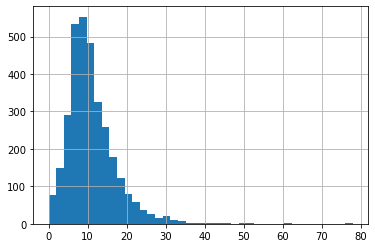

In [24]:
df_gas['Газ 1'].hist(bins =40)

<AxesSubplot:>

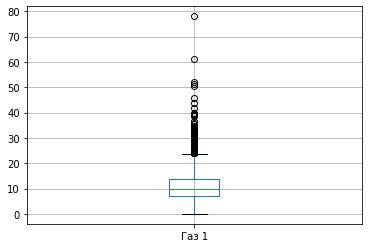

In [25]:
df_gas.boxplot(column = ['Газ 1'])

#### Вывод:

Данные верного типа без пропусков и дубликатов. 

Рассмотрим датасет bulk:

In [26]:
display(df_bulk) 
display(df_bulk.info())
display(df_bulk.describe())
display(df_bulk.duplicated().sum())


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


0

#### Вывод
Данные нужного типа, но имеют огромное количество пропущенных значений. Предполагаю, что это связанно с сочетанием сыпучих веществ, которые добавляются к партиям.

Рассмотрим bulk_time:

In [27]:
display(df_bulk_time)
display(df_bulk_time.info())
display(df_bulk_time.describe())
display(df_bulk_time.duplicated().sum())
 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


0

#### Вывод:

 Тип данных не корректен для большинства столбцов, имеются прощенные значения, дубликатов нет. В дальнейшем  работа с этими вестись не будет, поэтому оставляем его без внимания.(для построения модели для решения поставленной задачи данные не влияет, так как никакой информации об потребления электроэнергии, температуры и т.д. в данных нет) 


Рассмотрим df_write:


In [28]:
display(df_arc)
display(df_arc.describe())
display(df_arc.duplicated().sum())
display(df_arc.info())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


None

#### Вывод:

Данные нужного типа, но имеют огромное количество пропущенных значений. Предположим, что это произошло по той же причине что и датасете с информацией об сыпучих материалах.  


Рассмотрим df_wite_time:


In [29]:
display(df_wire_time)
display(df_wire_time.info()) 
display(df_wire_time.describe())
display(df_wire_time.duplicated().sum())


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


0

#### Вывод:
 
Также как и в случае с датасетом df_bulk_time мы имеем:
 - много отсуствующих значений
 - неверный тип данных.

И также как и с упомянотом выше датасетом вестись работа, с данной информацией, не будет.
   


### Итоговый вывод:

 - Провели исследовательский анализ данных 
 - Избавились от пропусков и выявили отсутствие в данных дубликатов
 - Изменили типы данных
 - Избавились от явных аномалий
 - Обнаружили, что после 2500 партии(в замерах из df_temp) данные имеются только для первых замеров, следовательно в других датасетах можно отбросить данные после 2500(так как данные df_temp являються целевым признаком)

Приступим к Шагу 3 


# Шаг 3
### Подготовка данных

In [30]:
df_temp_clean_1 = df_temp_clean
display(df_temp_clean_1)
df_arc_1 = df_arc.groupby(by ='key', as_index =False).sum()
display(df_arc_1)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569.0
15883,3238,2019-08-31 23:30:31,1584.0
15886,3239,2019-09-01 01:31:47,1598.0
15894,3240,2019-09-01 02:39:01,1617.0


,key,Активная мощность,Реактивная мощность
0,1,4.878147,3.183241
1,2,3.052598,1.998112
2,3,2.525882,1.599076
3,4,3.209250,2.060298
4,5,3.347173,2.252643
...,...,...,...
3209,3237,3.932467,2.828459
3210,3238,2.106529,1.681182
3211,3239,4.666754,3.111617
3212,3240,2.984083,2.483267


In [31]:
df_temp_clean = df_temp_clean.query('key < 2500')
df_bulk = df_bulk.query('key < 2500')
df_wire = df_wire.query('key < 2500')
df_arc = df_arc.query('key < 2500')
df_gas = df_gas.query('key < 2500')

In [32]:
df_temp_clean_1 = df_temp_clean_1.query('key < 2500')
df_arc_1 = df_arc_1.query('key < 2500')


Разделем температуру на первичную и на температуру, которую нужно предсказать

In [33]:
df_temp_clean_count = df_temp_clean.groupby(by ='key', as_index =False).count()
intermediate = df_temp_clean_count[df_temp_clean_count['Время замера'] == 1]['key'].tolist()
df_temp_clean_1 = df_temp_clean_1.query('key not in @intermediate')
df_temp_clean_1

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


In [34]:
df_temp_clean_1 = df_temp_clean_1.groupby(by= 'key').agg(['first','last']).reset_index()
df_temp_clean_1.columns = df_temp_clean_1.columns.droplevel()
df_temp_clean_1.columns = ['key', 'Время замера1', 'Время замера 2','Температура 1', 'Температура 2' ]
df_temp_clean_1 = df_temp_clean_1[['key', 'Температура 1', 'Температура 2']] 
df_temp_clean_1

,key,Температура 1,Температура 2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


In [35]:
df_all= (df_temp_clean_1.merge(df_arc_1, how = 'left', on = 'key')
                    .merge(df_wire, how = 'left', on = 'key')
                    .merge(df_bulk, how = 'left', on = 'key')
                    .merge(df_gas, how = 'left', on = 'key'))

df_all

,key,Температура 1,Температура 2,Активная мощность,Реактивная мощность,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,1571.0,1613.0,4.878147,3.183241,60.059998,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,29.749986
1,2,1581.0,1602.0,3.052598,1.998112,96.052315,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.555561
2,3,1596.0,1599.0,2.525882,1.599076,91.160157,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,28.554793
3,4,1601.0,1625.0,3.209250,2.060298,89.063515,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,18.841219
4,5,1576.0,1602.0,3.347173,2.252643,89.238236,9.11456,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,3.210690,2.360777,89.150879,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,90.0,NaN,256.0,NaN,129.0,223.0,7.125735
2471,2496,1554.0,1591.0,4.203064,2.810185,114.179527,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,122.0,NaN,256.0,NaN,129.0,226.0,9.412616
2472,2497,1571.0,1589.0,2.212379,1.851269,94.086723,9.04800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,230.0,NaN,124.0,226.0,6.271699
2473,2498,1591.0,1594.0,3.408725,2.355428,118.110717,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,101.0,NaN,206.0,NaN,129.0,207.0,14.953657


Заполним пропуски 0 


In [36]:
df_all = df_all.fillna(0)

 Удалим столбец 'key' за ненадобностью и возможных

In [37]:
df_all = df_all.drop(['key'], axis = 1)
df_all

,Температура 1,Температура 2,Активная мощность,Реактивная мощность,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1571.0,1613.0,4.878147,3.183241,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,1581.0,1602.0,3.052598,1.998112,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,1596.0,1599.0,2.525882,1.599076,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,1601.0,1625.0,3.209250,2.060298,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,1576.0,1602.0,3.347173,2.252643,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,1570.0,1591.0,3.210690,2.360777,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2471,1554.0,1591.0,4.203064,2.810185,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2472,1571.0,1589.0,2.212379,1.851269,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2473,1591.0,1594.0,3.408725,2.355428,118.110717,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


Разделим датасет на тестовую и обучающую выборки 

In [38]:
df_train, df_test =train_test_split (df_all, test_size = 0.30, random_state =12345)


Active power Reactive power

Проведем маcштабирование признаков

In [39]:
numeric = df_all.columns.tolist()
numeric = [i for i in numeric if i not in('Температура 2')]
scaler = MinMaxScaler()
scaler.fit(df_train[numeric])

df_train[numeric] = scaler.transform(df_train[numeric])
df_test[numeric] =  scaler.transform(df_test[numeric])

In [40]:
display(df_train.shape)
display(df_test.shape)

(1732, 29)

(743, 29)

### Вывод :
 - Отсекли не информативные данные и сгруппировали данные
 - Соединили данные в единую таблицу
 - Разделили выборки
 - Провели масштабирование
 
 Обучим модель в Шаге 4


# Шаг 4 
### Обучение модели

Определим признаки выборок

In [41]:
features_train = df_train.drop(['Температура 2'],axis = 1)
target_train = df_train['Температура 2']

features_test = df_test.drop(['Температура 2'],axis = 1)
target_test = df_test['Температура 2']

### Регрессия

In [54]:
LR = LinearRegression()
LR.fit(features_train, target_train)
predictions_train = LR.predict(features_train) 
predictions_test = LR.predict(features_test)
MAE_train_LR = mean_absolute_error(target_train, predictions_train)
MAE_test_LR = mean_absolute_error(target_test, predictions_test)
print("MAE на обучающей выборке: ", mean_absolute_error(target_train, predictions_train)) 
print("MAE на тестовой выборке: ", mean_absolute_error(target_test, predictions_test))


MAE на обучающей выборке:  7.895845966384075
MAE на тестовой выборке:  7.899406351769138


### Лес

In [43]:
RandomForest = RandomForestRegressor(n_estimators=80,max_depth=11, random_state=12345) 
RandomForest.fit(features_train, target_train)
predictions_train = RandomForest.predict(features_train) 
predictions_test = RandomForest.predict(features_test)
MAE_train_RandomForest = mean_absolute_error(target_train, predictions_train)
MAE_test_RandomForest = mean_absolute_error(target_test, predictions_test)
print("MAE на обучающей выборке: ", mean_absolute_error(target_train, predictions_train)) 
print("MAE на тестовой выборке: ", mean_absolute_error(target_test, predictions_test)) 

MAE на обучающей выборке:  3.5552400970151314
MAE на тестовой выборке:  6.232151731872546


### LGBM

In [44]:
%%time
LGBM = lgb.LGBMRegressor(boosting_type = 'gbdt',max_depth = 2, n_estimators = 600, objective = 'regression',
                     random_state = 13,  metric= ['MAE'])
LGBM.fit(features_train, target_train, verbose=10)
predictions_train = LGBM.predict(features_train) 
predictions_test = LGBM.predict(features_test)
MAE_train_LGBM = mean_absolute_error(target_train, predictions_train)
MAE_test_LGBM = mean_absolute_error(target_test, predictions_test)
print("MAE на обучающей выборке: ", mean_absolute_error(target_train, predictions_train)) 
print("MAE на тестовой выборке: ", mean_absolute_error(target_test, predictions_test))

MAE на обучающей выборке:  4.629741918981979
MAE на тестовой выборке:  6.090280833309022
CPU times: user 393 ms, sys: 36.5 ms, total: 430 ms
Wall time: 147 ms


### Catboost

In [45]:
%%time
CatBoost = CatBoostRegressor(iterations=600, depth=4, loss_function="MAE",
                          verbose=True,random_state = 13)

CatBoost.fit(features_train, target_train, verbose=10)
predictions_train = CatBoost.predict(features_train) 
predictions_test = CatBoost.predict(features_test)
MAE_train_cat = mean_absolute_error(target_train, predictions_train)
MAE_test_cat = mean_absolute_error(target_test, predictions_test)

print("MAE на обучающей выборке: ", mean_absolute_error(target_train, predictions_train)) 
print("MAE на тестовой выборке: ", mean_absolute_error(target_test, predictions_test))

0:	learn: 9.9739482	total: 53ms	remaining: 31.7s
10:	learn: 9.2990229	total: 64ms	remaining: 3.43s
20:	learn: 8.7968939	total: 76.9ms	remaining: 2.12s
30:	learn: 8.4370715	total: 87.5ms	remaining: 1.61s
40:	learn: 8.0710731	total: 97.3ms	remaining: 1.33s
50:	learn: 7.7726335	total: 106ms	remaining: 1.14s
60:	learn: 7.5711531	total: 114ms	remaining: 1.01s
70:	learn: 7.3441444	total: 123ms	remaining: 915ms
80:	learn: 7.1258201	total: 131ms	remaining: 841ms
90:	learn: 6.9341573	total: 140ms	remaining: 782ms
100:	learn: 6.7818421	total: 150ms	remaining: 739ms
110:	learn: 6.6440336	total: 160ms	remaining: 706ms
120:	learn: 6.5278432	total: 171ms	remaining: 678ms
130:	learn: 6.4331585	total: 181ms	remaining: 647ms
140:	learn: 6.3216341	total: 192ms	remaining: 624ms
150:	learn: 6.2199221	total: 201ms	remaining: 599ms
160:	learn: 6.1591057	total: 211ms	remaining: 576ms
170:	learn: 6.0892553	total: 221ms	remaining: 554ms
180:	learn: 6.0136403	total: 230ms	remaining: 533ms
190:	learn: 5.9423894	

In [57]:
data = {'model':['Linear', 'Forest', 'LGBM', 'CAT'],
        'resul_mae_train':[MAE_train_LR, MAE_train_RandomForest,MAE_train_LGBM, MAE_train_cat],
        'result_mae_test':[MAE_test_LR, MAE_test_RandomForest,MAE_test_LGBM, MAE_test_cat]}

In [58]:
data_result = pd.DataFrame(data)
data_result

,model,resul_mae_train,result_mae_test
0,Linear,7.895846,7.899406
1,Forest,7.895846,7.899406
2,LGBM,4.629742,6.090281
3,CAT,4.813025,6.044502


In [59]:
#plt.figure(figsize =(12,12))
#data_result.plot(kind= 'bar', color = 'b')
#plt.xlabel('models')
#plt.ylabel('resul_mae_train')
#plt.title('Сравнение моделей')
#plt.show()

### Вывод:
    - Определили признаки 
    - Протестировали модели
    - Пришли к выводу, что с задачей лучше всего справился CatBoost
В финальном шаге про тестируем на тестовой выборке данную модель


# Шаг 6
### Протестируем модель на тестовой выборке 


In [60]:
CB = CatBoostRegressor(iterations=600, depth=4, loss_function="MAE",
                          verbose=True,random_state = 13)

CB.fit(features_train, target_train, verbose=0)
predictions = CB.predict(features_test)
print('Результат МАЕ на тестовой выборке:', mean_absolute_error(predictions,target_test))

Результат МАЕ на тестовой выборке: 6.0445024306832025


Построим график важности факторов

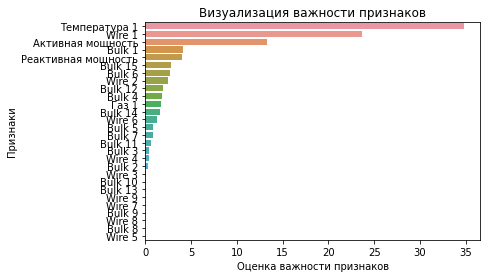

In [61]:
y_train = target_train
y_test = target_test
X_train = features_train
X_test = features_test
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(CB)

### Вывод:
   
   Модель прошла тест успешно и показала хорошие результа MAE в 6.04 на тестовой выборке.

# Итоговый отчет:
 - данные загружены и оценены
 - исследовательский анализ данных проведен
 - переработка данных проведена успешно
 - признаки созданы и очищены
 - обучено 4 модели : LightGBM,LinearRegression также попробуем обучить RandomForesst и СatBoost
 - лучшая из них выбрана и протестирована
 - необходимый результат достигнут

Можно считать, что поставленной задачей справились.
